<center> <h1> IBM Data Science</h1></center>  

<center><h2> Capstone Project: Demographic classification of Ottawa Neighbourhoods</h2></center>  

<center><h4> Alexandre Poulin</h4></center>  

    


## Table of contents

* [Introduction: Business Problem](#introduction)
* [Data Acquisition](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

So far in the capstone project class excersizes, we have been clustering neighbourhoods based on similarities of various businesses in different neighbourhood. This can be useful if you live in a neighbourhood and want to move to a neighbourhood, or if you are a business owner and want to see what parts of a city has similar businesses to each other. The goal of this project will be to see if there are any connection to the demographics of the neighbourhood and the venues in the neighbourhood. If such a connection exist, then it can be usefull to know for various reasons:

<ul>
    <li> Someone who is looking to move may be interested in finding an area near them which are popular amung others who share a demographic. This can improve their overall happiness as opposed to finding similar neighbourhoods to where they already were. </li>
    <li> A business which may have a target demographic may want to know which neighbourhoods are already popular amung those demographics.</li>
    <li> Business owners would like to know who their audience are so that they can focus more on a particular group</li>
    <li> Maybe a particular neighbourhood is popular to a particular group only because it has a high density of a particular type of buissness which is primarily enjoyed only by a single demographic. </li>
</ul>

The questions we will aim to answer are the following: Can we make a connection between the demographics of a neighbourhood and the venues in that neighbourhood? Because it would be interesting for me based on where I live, the city which will be analysed will be Ottawa, Canada.




## Data Acquisition <a name="data"></a>

To complete this project, we will use an open source GEOJSON file (https://gist.githubusercontent.com/mattleduc/10549018/raw/b76778e347fde6ae7cbec2066be1dcb8119aa93e/ons.geojson) which contains data on the outline of each neighbourhood, as well as demographic information on the population there. We can also use the location data to acquire data from Foursquare for the venues in the neighbourhoods. Using both of these data sets together, we can extract trends to better understand the state of each neighbourhood.


In [1]:
import requests
import pandas as pd
import numpy as np

url = r"https://gist.githubusercontent.com/mattleduc/10549018/raw/b76778e347fde6ae7cbec2066be1dcb8119aa93e/ons.geojson"
response = requests.get(url).json()

geometry = [n['geometry']['coordinates'] for n in response["features"]]
shape =[n['geometry']['type'] for n in response["features"]]

listOfDemographics = response["features"][0]["properties"].keys()
print("There are a total of " , len(listOfDemographics), " properties for each neighbourhood.")

Ottawa_Data = pd.DataFrame([response["features"][i]["properties"] for i in range(len(response["features"]))])
Ottawa_Data.head()
for d in listOfDemographics:
    print(d)

There are a total of  113  properties for each neighbourhood.
OBJECTID
names
BLKPOP2011
TOTDWL2011
URBDWL2011
AREASQKM
NID
ID
Neighborhood
Population
Total Area of Neighbourhood (km2)
Population: Aged 0 - 9 yrs (%)
Population: Aged 10 - 19 yrs (%)
Population: Aged 20 - 29 yrs (%)
Population: Aged 30 - 39 yrs (%)
Population: Aged 40 - 49 yrs (%)
Population: Aged 50 - 59 yrs (%)
Population: Aged 60 - 69 yrs (%)
Population: Aged 70 - 79 yrs (%)
Population: Aged 80+ yrs (%)
Total Male Population
Total Female Population
Total Population
Population: Children under 6 yrs (%)
Population: Children aged 6-14 yrs (%)
Population: Children aged 15-17 yrs (%)
Population: Children aged 18-24 yrs (%)
Population: Children aged 25 yrs (%)
Population: Persons living with relatives (%)
Population: Persons living with non-relatives (%)
Population: Persons living alone (%)
Population: Persons living in census family (%)
Population: Seniors living with relatives (%)
Population: Seniors living with non-relati

For each neighbourhood, we can calculate the centroid using the geometric data the response. To calculate the centroid, we use :
$$C_x=\frac{1}{6A}\sum_{i=0}^{n-1}(x_i+x_{i+1})(x_i y_{i+1}-x_{i+1}y_i)$$
$$C_y=\frac{1}{6A}\sum_{i=0}^{n-1}(y_i+y_{i+1})(x_i y_{i+1}-x_{i+1}y_i)$$

We could calculate the area of each neighbourhood using:
$$A=\frac{1}{2}\sum_{i=0}^{n-1}(x_i y_{i+1}-x_{i+1}y_i)$$
In the data, we have the AREASQKM column that we could use for A. We calculate this instead as a sanity check.

All above formulas from https://en.wikipedia.org/wiki/Centroid.

We will need to find the furthest point away from the centroid to make sure we select a radius at least that big when looking up Foursquare data. To do this, one could try to compute:
$$R_{\rm{max}}=\max_{i}\sqrt{(C_x-x_i)^2+(C_y-y_i)^2}$$
However since we have all the values in longitude and latitude, it doesn't give us an answer in km. Instead we need to use:
$$R=2R_{\rm Earth}\sin^{-1}\left[\sqrt{\sin^2\left(\frac{\phi_2-\phi_1}{2}\right)+\cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\lambda_2-\lambda_1}{2}\right)}\right]$$
Where $\phi_1$, $\phi_2$, $\lambda_1$, and $\lambda_2$ are the two latitudes and two longitude, respectively; and $R_{\rm Earth}=6,371,000$ meters is the radius of the Earth. This comes from the Haversine formula. More information can be found at https://en.wikipedia.org/wiki/Haversine_formula.

In [2]:
##geometry has the form [[[long1,lat1],[long2,lat2],...]] for polygon, [[[[long1,lat1],[long2,lat2],...]],[[other polygons]]] for multipolygon

def Area(geometry,shape='Polygon'):
    if shape=='MultiPolygon':
        return sum([sum(i[0]*iplus1[1]-i[1]*iplus1[0] for i,iplus1 in zip([[0,0]]+polygon[0],polygon[0]))/2 for polygon in geometry])
    return sum([sum(i[0]*iplus1[1]-i[1]*iplus1[0] for i,iplus1 in zip([[0,0]]+polygon,polygon))/2 for polygon in geometry])

def centroid(geometry,shape='Polygon'):
    area = Area(geometry,shape)
    if shape=='MultiPolygon':
        cx= sum([sum((i[0]+iplus1[0])*(i[0]*iplus1[1]-i[1]*iplus1[0]) for i,iplus1 in zip([[0,0]]+polygon[0],polygon[0]))/6 for polygon in geometry])/area
        cy= sum([sum((i[1]+iplus1[1])*(i[0]*iplus1[1]-i[1]*iplus1[0]) for i,iplus1 in zip([[0,0]]+polygon[0],polygon[0]))/6 for polygon in geometry])/area
        return (cx,cy)
    cx= sum([sum((i[0]+iplus1[0])*(i[0]*iplus1[1]-i[1]*iplus1[0]) for i,iplus1 in zip([[0,0]]+polygon,polygon))/6 for polygon in geometry])/area
    cy= sum([sum((i[1]+iplus1[1])*(i[0]*iplus1[1]-i[1]*iplus1[0]) for i,iplus1 in zip([[0,0]]+polygon,polygon))/6 for polygon in geometry])/area
    return [cx,cy]

def findR(phi1,phi2,lambda1,lambda2):
    return 2*6371000*np.arcsin(np.sqrt(np.sin((phi2-phi1)/2*np.pi/180)**2+np.cos(phi1*np.pi/180) * np.cos(phi2*np.pi/180) * np.sin((lambda2-lambda1)/2*np.pi/180)**2))

def maxRadius(geometry,shape='Polygon'):
    lambda1,phi1=np.array(centroid(geometry,shape))
    maxR = 0
    if shape=='MultiPolygon':
        for polygon in geometry:
            for coord in polygon[0]:
                curR = findR(phi1,coord[1],lambda1,coord[0])
                if curR>maxR:
                    maxR=curR
    else:
        for polygon in geometry:
            for coord in polygon:
                curR = findR(phi1,coord[1],lambda1,coord[0])
                if curR>maxR:
                    maxR=curR
    return maxR
    


In [3]:
centroidCoord =[centroid(g,s) for g,s in zip(geometry,shape)]
radii = [maxRadius(g,s) for g,s in zip(geometry,shape)]

Ottawa_Data=Ottawa_Data.assign(centroidLat=[x[1] for x in centroidCoord],centroidLong=[x[0] for x in centroidCoord],radius=radii)


In [4]:
Ottawa_Data.head()

AREASQKM  BLKPOP2011  Citizenship Status: Canadian citizenship (%)  \
0  4.441791     17249.0                                           1.9   
1  2.232044      7283.0                                           8.2   
2  2.543752      5167.0                                           4.4   
3  3.354998      5104.0                                           3.8   
4  1.370700      4354.0                                           3.0   

   Citizenship Status: immigrants (%)  Citizenship Status: non-immigrants (%)  \
0                                13.6                                    86.1   
1                                28.1                                    71.1   
2                                23.5                                    75.8   
3                                17.6                                    82.3   
4                                23.6                                    76.1   

   Citizenship Status: non-permanent residents (%)  \
0                                              0.1   
1                                              0.7   
2                                              0.3   
3                                              0.0   
4                                              0.0   

   Citizenship Status: recent immigrants (2006-2011) (%)  \
0                                                0.2       
1                                                7.0       
2                                                2.6       
3                                                1.7       
4                                                2.9       

   Community Engagement: number of registered voters in neighbourhood  \
0                                            12112.0                    
1                                             5276.0                    
2                                             9274.0                    
3                                             2469.0                    
4                                             3345.0                    

   Community Engagement: registered voters who voted in 2010 Mayoral Elections (%)  \
0                                               37.2                                 
1                                               35.9                                 
2                                               45.1                                 
3                                               43.1                                 
4                                               38.4                                 

   Education: (aged 25-64) some postsecondary certificate, diploma or degree (%)  \
0                                               74.7                               
1                                               68.5                               
2                                               76.7                               
3                                               72.9                               
4                                               65.2                               

   ...  TOTDWL2011  Total Area of Neighbourhood (km2)  \
0  ...      5983.0                               4.44   
1  ...      3260.0                               2.23   
2  ...      2143.0                               2.54   
3  ...      1999.0                               3.35   
4  ...      1795.0                               1.37   

   Total Female Population  Total Male Population  Total Population  \
0                   8696.0                 8555.0           17264.0   
1                   3828.0                 3430.0            7245.0   
2                   2644.0                 2486.0            5123.0   
3                   2727.0                 2405.0            5132.0   
4                   2334.0                 2018.0            4356.0   

   URBDWL2011                                 names  centroidLat  \
0      5938.0                             Barrhaven    45.274340   
1      3179.0  Beacon Hi

We define our Foursquare credentials and version below. This cell will be hidden to keep this informations secret.

In [5]:
# The code was removed by Watson Studio for sharing.

Because the radius we're using is going to be the biggest distance between the centroid and the border, the radius might include venues outside of the neighbourhood that we need to eliminate from the query results. We will thus need to write a function to test for this. The easiest way to check for this is to imagine sliding the coordinate of the venue along the latitude and see how many times it crosses the borderes. If it crosses an odd number of times, it was in the neighbourhood, but if it crosses and odd number of times, then it wasn't. Say the venus is at $v_x$ and $v_y$. Then it will cross a section of the border if:
$$y_i<v_y<y_{i+1} \mbox{ and }  v_y-y_i> \frac{y_{i+1}-y_i}{x_{i+1}-x_{i}}(v_x-x_i)$$
or
$$y_i>v_y>y_{i+1} \mbox{ and }  v_y-y_i< \frac{y_{i+1}-y_i}{x_{i+1}-x_{i}}(v_x-x_i)$$
It should be noted that if we ever have a situation where $x_{i+1}=x_{i}$ then this is a horizontal line that would not be crossed, so we can ignore it.

In the following, we need to make an explore request to get a list of venues withing the radius we calculated. We make a function that can get the venue information.

In [6]:
def check(x,y,geometry,shape):
    numberOfPasses= 0
    if shape=='MultiPolygon':
        for polygon in geometry:
            for i,iplus1 in zip([[0,0]]+polygon[0],polygon[0]):
                xi, yi = i 
                xiplus1, yiplus1 = iplus1 
                if xi==xiplus1:
                    continue
                if yi < y and y < yiplus1:
                    if y-yi> (yiplus1-yi)/(xiplus1-xi)*(x-xi):
                        numberOfPasses+=1
                elif yi > y and y > yiplus1:
                    if y-yi< (yiplus1-yi)/(xiplus1-xi)*(x-xi):
                        numberOfPasses+=1
    else:
        for polygon in geometry:
            for i,iplus1 in zip([[0,0]]+polygon,polygon):
                xi, yi = i 
                xiplus1, yiplus1 = iplus1 
                if xi==xiplus1:
                    continue
                if yi < y and y < yiplus1:
                    if y-yi> (yiplus1-yi)/(xiplus1-xi)*(x-xi):
                        numberOfPasses+=1
                elif yi > y and y > yiplus1:
                    if y-yi< (yiplus1-yi)/(xiplus1-xi)*(x-xi):
                        numberOfPasses+=1
    return (numberOfPasses%2)==1

def getNearbyVenues(names, latitudes, longitudes,geometry,shape, radius,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng, rad,g,s in zip(names, latitudes, longitudes, radius,geometry,shape):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
        
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results if check(v['venue']['location']['lng'],v['venue']['location']['lat'],g,s)])
        except:
            print("issue on ",name, lat, lng)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
Ottawa_venues = getNearbyVenues(names=Ottawa_Data['names'],
                                   latitudes=Ottawa_Data['centroidLat'],
                                   longitudes=Ottawa_Data['centroidLong'],
                                   geometry = geometry,
                                   shape=shape,
                                   radius=Ottawa_Data['radius']
                                  )

Barrhaven
Beacon Hill South - Cardinal Heights
Beaverbrook
Bells Corners East
Bells Corners West
Billings Bridge - Alta Vista
Hunt Club Upper -Blossom Park - Timbermill
Borden Farm - Stewart Farm - Parkwood Hills - Fisher Glen
Braemar Park - Bel Air Heights - Copeland Park
Briar Green - Leslie Park
Carleton Heights - Rideauview
Carlington
Laurentian
Carlingwood West - Glabar Park - McKellar Heights
Carson Grove - Carson Meadows
Centrepointe
Centretown
Orleans Chapel Hill
Cityview - Skyline - Fisher Heights
Civic Hospital-Central Park
Crestview - Meadowlands
Emerald Woods - Sawmill Creek
Glebe - Dows Lake
Greenboro East
Hawthorne Meadows - Sheffield Glen
Hintonburg - Mechanicsville
Hunt Club - Ottawa Airport
Hunt Club East - Western Community
Iris
Island Park
Katimavik - Hazeldean
Ledbury - Heron Gate - Ridgemont - Elmwood
Lindenlea - New Edinburgh
Lowertown
Orleans Village - Chateauneuf
Overbrook - McArthur
Playfair Park - Lynda Park - Guildwood Estates
Qualicum - Redwood Park
Orleans 

Now that we have the venue data, we will do a one hot encoding for each venue category, and then look at the total count for each neighbourhood.

In [8]:
# one hot encoding
Ottawa_onehot = pd.get_dummies(Ottawa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Ottawa_onehot['Neighbourhood'] = Ottawa_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Ottawa_onehot.columns[-1]] + list(Ottawa_onehot.columns[:-1])
Ottawa_onehot = Ottawa_onehot[fixed_columns]

Ottawa_onehot.head()

Neighbourhood  Afghan Restaurant  Airport  Airport Service  \
0     Barrhaven                  0        0                0   
1     Barrhaven                  0        0                0   
2     Barrhaven                  0        0                0   
3     Barrhaven                  0        0                0   
4     Barrhaven                  0        0                0   

   American Restaurant  Arcade  Art Gallery  Art Museum  Arts & Crafts Store  \
0                    0       0            0           0                    0   
1                    0       0            0           0                    0   
2                    0       0            0           0                    0   
3                    0       0            0           0                    0   
4                    0       0            0           0                    0   

   Asian Restaurant  ...  Turkish Restaurant  Vegetarian / Vegan Restaurant  \
0                 0  ...                   0                              0   
1                 0  ...                   0                              0   
2                 0  ...                   0                              0   
3                 0  ...                   0                              0   
4                 0  ...                   0                              0   

   Video Store  Vietnamese Restaurant  Warehouse Store  Waterfall  Whisky Bar  \
0            0                      0                0          0           0   
1            0                      0                0          0           0   
2            0                      0                0          0           0   
3            0                      0                0          0           0   
4            0                      0                0          0           0   

   Wine Bar  Wings Joint  Yoga Studio  
0         0            0            0  
1         0            0            0  
2         0            0            0  
3         0            0            0  
4         0            0            0  

[5 rows x 225 columns]

In [9]:
Ottawa_grouped = Ottawa_onehot.groupby('Neighbourhood').mean().reset_index()
Ottawa_grouped.head(10)

Neighbourhood  Afghan Restaurant  \
0                                          Barrhaven           0.000000   
1                                           Bayshore           0.000000   
2               Beacon Hill South - Cardinal Heights           0.000000   
3                                        Beaverbrook           0.000000   
4                                 Bells Corners East           0.000000   
5                                 Bells Corners West           0.000000   
6                       Billings Bridge - Alta Vista           0.016393   
7                                   Blackburn Hamlet           0.000000   
8  Borden Farm - Stewart Farm - Parkwood Hills - ...           0.000000   
9     Braemar Park - Bel Air Heights - Copeland Park           0.000000   

   Airport  Airport Service  American Restaurant    Arcade  Art Gallery  \
0      0.0              0.0                0.000  0.000000          0.0   
1      0.0              0.0                0.000  0.000000          0.0   
2      0.0              0.0                0.000  0.000000          0.0   
3      0.0              0.0                0.000  0.000000          0.0   
4      0.0              0.0                0.000  0.000000          0.0   
5      0.0              0.0                0.125  0.000000          0.0   
6      0.0              0.0                0.000  0.016393          0.0   
7      0.0              0.0                0.000  0.000000          0.0   
8      0.0              0.0                0.000  0.000000          0.0   
9      0.0              0.0                0.000  0.000000          0.0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  ...  Turkish Restaurant  \
0         0.0                  0.0          0.000000  ...                 0.0   
1         0.0                  0.0          0.000000  ...                 0.0   
2         0.0                  0.0          0.000000  ...                 0.0   
3         0.0                  0.0          0.000000  ...                 0.0   
4         0.0                  0.0          0.111111  ...                 0.0   
5         0.0                  0.0          0.125000  ...                 0.0   
6         0.0                  0.0          0.000000  ...                 0.0   
7         0.0                  0.0          0.000000  ...                 0.0   
8         0.0                  0.0          0.000000  ...                 0.0   
9         0.0                  0.0          0.000000  ...                 0.0   

   Vegetarian / Vegan Restaurant  Video Store  Vietnamese Restaurant  \
0                       0.000000          0.0                    0.0   
1                       0.000000          0.0                    0.0   
2                       0.000000          0.0                    0.0   
3                       0.000000          0.0                    0.0   
4                       0.000000          0.0                    0.0   
5                       0.000000          0.0                    0.0   
6                       0.016393          0.0                    0.0   
7                       0.000000          0.0                    0.0   
8                       0.000000          0.0                    0.0   
9                       0.000000          0.0                    0.0   

   Warehouse Store  Waterfall  Whisky Bar  Wine Bar  Wings Joint  Yoga Studio  
0              0.0        0.0         0.0       0.0          0.0          0.0  
1              0.0        0.0         0.0       0.0          0.0          0.0  
2              0.0        0.0         0.0       0.0          0.0          0.0  
3              0.0        0.0         0.0       0.0          0.0          0.0  
4              0.0        0.0         0.0       0.0          0.0          0.0  
5              0.0        0.0         0.0       0.0          0.0          0.0  
6              0.0        0.0         0.0       0.0          0.0          0.0  
7              0.0        0.0         0.0       0.0          0

In [10]:
Ottawa_grouped.shape

(105, 225)

We now have all the data frames that we need:
<ul>
    <li> Ottawa_Data2: contains all the demographic data for the neighbourhoods</li>
    <li> geometry, shape: contains the boundary and type of boundary for each neighbourhoods</li>
    <li> Ottawa_grouped: contains all the information on venues in each neighbourhood. </li>
</ul>

The next step is to start working with the data.

## Methodology <a name="methodology"></a>

In this project, we want to see if there are any connections between the demographics of a neighbourhood and the types of venues in neighbourhood. This analysis will follow 3 steps:
<ol>
    <li>Cleaning: Both the Ottawa_Data and Ottawa_grouped have >100 columns. We will see if we can reduce the number of columns by seeing if any are similar, could be aggregated, or if they are not relevant.</li>
    <li>Clustering: We will individually cluster the neighbourhoods based on demographics and on venues using k-means clustering.</li>
    <li>Comparison: We will use a heat map to see the correlation between the clusters.</li>
</ol>

## Analysis <a name="analysis"></a>

Let's start by taking a look at columns in the Ottawa_Data2 data frame. They can be split up into a few groups. Let's go over the first group:
<ul>
    <li>OBJECTID</li>
    <li>names</li>
    <li>BLKPOP2011</li>
    <li>TOTDWL2011</li>
    <li>URBDWL2011</li>
    <li>AREASQKM</li>
    <li>NID</li>
    <li>ID</li>
    <li>Neighborhood, </li>
    <li>Population</li>
    <li>Total Area of Neighbourhood (km2)</li>
    <li>Total Population</li>
</ul>
From these, we will only use the Neighborhood, AREASQKM and Population column. The other columns are either duplicated, irrelevant, or of unknown meaning. Let's go and remove the other columns.

In [11]:
Ottawa_cleaned = Ottawa_Data.copy()
Ottawa_cleaned.drop(columns=['OBJECTID','names','BLKPOP2011','TOTDWL2011','URBDWL2011','NID','ID','Total Area of Neighbourhood (km2)','Total Population'],inplace=True)
Ottawa_cleaned.rename(columns={'Neighborhood':'Neighbourhood'},inplace=True)
Ottawa_cleaned.head()

AREASQKM  Citizenship Status: Canadian citizenship (%)  \
0  4.441791                                           1.9   
1  2.232044                                           8.2   
2  2.543752                                           4.4   
3  3.354998                                           3.8   
4  1.370700                                           3.0   

   Citizenship Status: immigrants (%)  Citizenship Status: non-immigrants (%)  \
0                                13.6                                    86.1   
1                                28.1                                    71.1   
2                                23.5                                    75.8   
3                                17.6                                    82.3   
4                                23.6                                    76.1   

   Citizenship Status: non-permanent residents (%)  \
0                                              0.1   
1                                              0.7   
2                                              0.3   
3                                              0.0   
4                                              0.0   

   Citizenship Status: recent immigrants (2006-2011) (%)  \
0                                                0.2       
1                                                7.0       
2                                                2.6       
3                                                1.7       
4                                                2.9       

   Community Engagement: number of registered voters in neighbourhood  \
0                                            12112.0                    
1                                             5276.0                    
2                                             9274.0                    
3                                             2469.0                    
4                                             3345.0                    

   Community Engagement: registered voters who voted in 2010 Mayoral Elections (%)  \
0                                               37.2                                 
1                                               35.9                                 
2                                               45.1                                 
3                                               43.1                                 
4                                               38.4                                 

   Education: (aged 25-64) some postsecondary certificate, diploma or degree (%)  \
0                                               74.7                               
1                                               68.5                               
2                                               76.7                               
3                                               72.9                               
4                                               65.2                               

   Education: (aged 25-64) with high school diploma or equivalent (%)  ...  \
0                                               21.4                   ...   
1                                               21.6                   ...   
2                                               18.3                   ...   
3                                               21.8                   ...   
4                                               25.2                   ...   

   Religion: Traditional (Aboriginal) Spirituality (%)  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   Religion: Visible minority (%)  Religion: with Aboriginal identity (%)  \
0                            12.8                                     1.9   
1                            2

For the next categories, there are many subdivisions such as age for the population, income, etc. We use a heatmap of a correlation matrix to see if any variables behave the same and so we can use larger categories. Note that because of the small size of the heatmap, not all the column names appear.

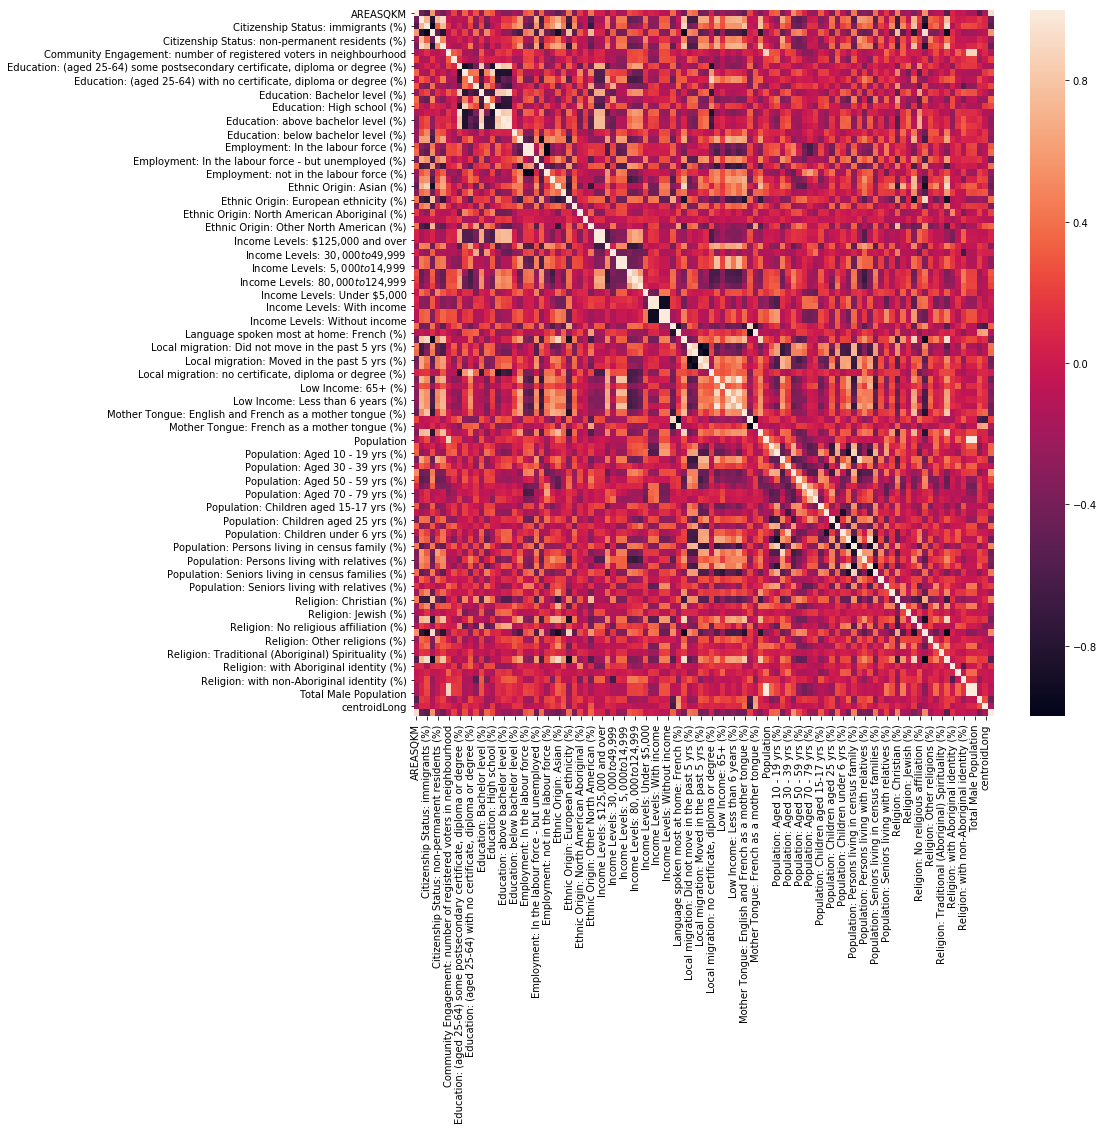

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

correlationMat = Ottawa_cleaned.corr()

f, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(Ottawa_cleaned.corr())


From the heatmap, we will make a few changes

With repect to Citizenship Status, we will keep:
<ul>
    <li>"Citizenship Status: immigrants (%)"</li>
    <li>"Citizenship Status: non-immigrants (%)"</li>
</ul>
and drop the rest. The dropped columns have similar correlations to the "Citizenship Status: immigrants (%)" column.

For the Community Engagement columns, these don't correlate much with any other variables so they will be dropped.

Next we look at the education columns:
<ul>
    <li>New Column "Education: non-bachelor" defined as the sum of the "Education: Apprenticeship or trades (%)", "Education: College, CEGEP or other non-university (%)", and "Education: High school (%)" columns, which will be dropped</li>
    <li>"Education: bachelor level or above (%)"</li>
</ul>
We will drop all the other columns as they have the same or similar information as the two columns will will use.

For the Employment columns:
<ul>
    <li>"Employment: In the labour force (and employed) (%)": keep</li>
    <li>"Employment: In the labour force - but unemployed (%)": keep</li>  
</ul>
and drop the rest. The dropped columns have similar correlations and information.

For the Ethnic Origin, Language and Mother Tongue, we will keep all the columns at the moment.

For the Income levels, we will make the following changes:
<ul>
    <li>New Column "Income Level: over \$50,000" defined as the sum of the "Income Levels: \$100,000 and over", "Income Levels: \$80,000 to \$99,999", and"Income Levels: \$50,000 to \$79,999" columns</li>
    <li>Keep "Income Levels: Under $5,000", "Income Levels: $15,000 to $29,999", "Income Levels: \$30,000 to \$49,999", "Income Levels: \$5,000 to \$14,999", "Income Levels: With income" and "Income Levels: Without income"</li>
</ul>
and drop the rest.

For the Local migration, we will keep:
<ul>
    <li>"Local migration: Did not move in the past 5 yrs (%)"</li>
    <li>"Local migration: Moved in the past 5 yrs (%)"</li>
    <li>"Local migration: no certificate, diploma or degree (%)"</li>
</ul>
And drop the rest.

For the Low Income, we will keep:
<ul>
    <li>"Low Income: 65+ (%)"</li>
    <li>"Low Income: Total population (LIM-AT) (%)"
</ul>
And drop the rest.

We will drop the "Total Female Population" and "Total Male Population" as they have the same information as the total population. 
We will also combine "Population: Aged 70 - 79 yrs (%)" and "Population: Aged 80+ yrs (%)" into a single column "Population: Aged 70+ yrs (%)"

In [13]:
##First we make the new columns
Ottawa_cleaned["Education: non-bachelor"]=Ottawa_cleaned[["Education: Apprenticeship or trades (%)","Education: College, CEGEP or other non-university (%)","Education: High school (%)"]].sum(axis=1)
Ottawa_cleaned["Income Level: over \$50,000"]=Ottawa_cleaned[["Income Levels: $100,000 and over","Income Levels: $80,000 to $99,999","Income Levels: $50,000 to $79,999"]].sum(axis=1)
Ottawa_cleaned["Population: Aged 70+ yrs (%)"]=Ottawa_cleaned[["Population: Aged 70 - 79 yrs (%)","Population: Aged 80+ yrs (%)"]].sum(axis=1)


#Then we drop all the unneeded columns
Ottawa_cleaned.drop(columns=['Citizenship Status: Canadian citizenship (%)',
               'Citizenship Status: non-permanent residents (%)',
               'Citizenship Status: recent immigrants (2006-2011) (%)',
               'Community Engagement: number of registered voters in neighbourhood',
               'Community Engagement: registered voters who voted in 2010 Mayoral Elections (%)',
               'Education: (aged 25-64) some postsecondary certificate, diploma or degree (%)',
               'Education: (aged 25-64) with high school diploma or equivalent (%)',
               'Education: (aged 25-64) with no certificate, diploma or degree (%)',
               'Education: Apprenticeship or trades (%)',
               'Education: Bachelor level (%)',
               'Education: College, CEGEP or other non-university (%)',
               'Education: High school (%)',
               'Education: Postsecondary (%)',
               'Education: bachelor level or above (%)',
               'Education: below bachelor level (%)',
               'Employment: Did not work in 2010 (%)',
               'Employment: In the labour force (%)',
               'Employment: Worked in 2010 (%)',
               'Employment: not in the labour force (%)',
               'Income Levels: $100,000 and over',
               'Income Levels: $125,000 and over',
               'Income Levels: $5,000 - $14,999',
               'Income Levels: $50,000 to $79,999',
               'Income Levels: $80,000 to $124,999',
               'Income Levels: $80,000 to $99,999',
               'Income Levels: With after-tax income',
               'Income Levels: Without after-tax income',
               'Local migration: Did not move in the past year (%)',
               'Local migration: Moved in the past year (%)',
               'Low Income: 18 to 64 years (%)',
               'Low Income: Less than 18 years (%)',
               'Low Income: Less than 6 years (%)',
               'Total Female Population',
               'Total Male Population',
               "Population: Aged 80+ yrs (%)",
               "Population: Aged 70 - 79 yrs (%)"
              ],inplace=True)

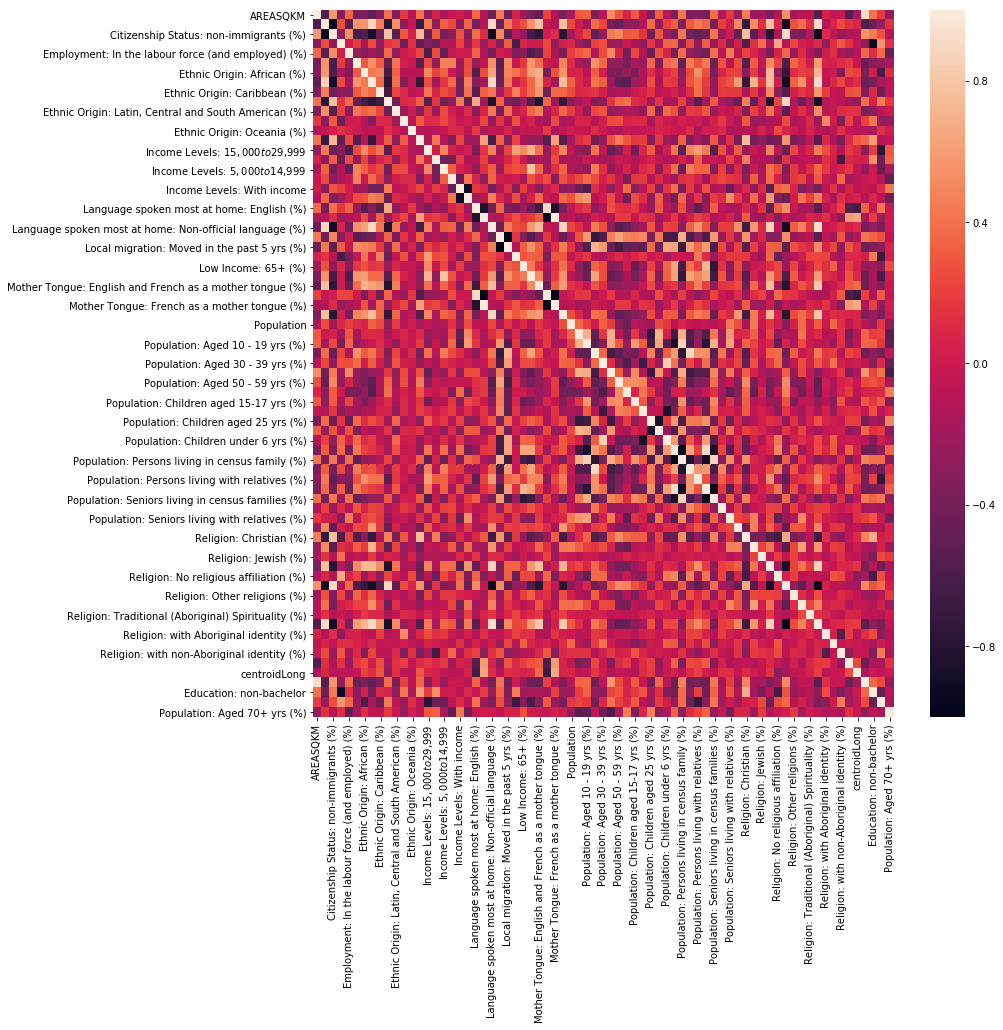

In [14]:
correlationMat = Ottawa_cleaned.corr()

f, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(Ottawa_cleaned.corr())

At this point we can apply the k-means algorithm to this data set. First, we will need to decide which number of cluster is correct using the elbow method.

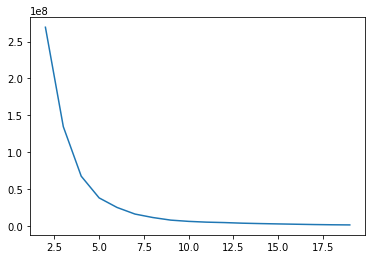

In [15]:
from sklearn.cluster import KMeans

Ottawa_cleaned_Fit = Ottawa_cleaned.drop(columns=['Neighbourhood','centroidLong','centroidLat','AREASQKM','Population'])

scores = []
xaxis=[k for k in range(2,20)]
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Ottawa_cleaned_Fit)
    scores.append(-kmeans.score(Ottawa_cleaned_Fit))

plt.plot(xaxis,scores)

We see that 5 seems to be the correct number of clusters. Let's add each cluster label to the Ottawa_cleaned dataFrame

In [16]:
kmeans = KMeans(n_clusters=5).fit(Ottawa_cleaned_Fit)

Ottawa_cleaned['Cluster']=pd.Series(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_,columns=Ottawa_cleaned_Fit.columns)
centers.head()

Citizenship Status: immigrants (%)  Citizenship Status: non-immigrants (%)  \
0                           21.053846                               78.253846   
1                            8.736364                               90.500000   
2                           24.952778                               73.098611   
3                           11.554545                               87.790909   
4                           18.500000                               80.900000   

   Education: above bachelor level (%)  \
0                            13.438462   
1                             7.890909   
2                            15.369444   
3                            11.181818   
4                            13.600000   

   Employment: In the labour force (and employed) (%)  \
0                                          66.492308    
1                                          69.836364    
2                                          60.966667    
3                                          69.136364    
4                                          64.000000    

   Employment: In the labour force - but unemployed (%)  \
0                                           3.507692      
1                                           2.572727      
2                                           4.340278      
3                                           2.600000      
4                                           1.100000      

   Ethnic Origin: African (%)  Ethnic Origin: Asian (%)  \
0                    3.069231                 16.284615   
1                    0.309091                  2.618182   
2                    5.800000                 17.751389   
3                    1.263636                  8.090909   
4                    6.600000                 10.600000   

   Ethnic Origin: Caribbean (%)  Ethnic Origin: European ethnicity (%)  \
0                      1.607692                              69.476923   
1                      0.200000                              82.818182   
2                      2.070833                              67.029167   
3                      0.545455                              74.490909   
4                      0.800000                              73.800000   

   Ethnic Origin: Latin, Central and South American (%)  ...  \
0                                           1.061538     ...   
1                                           0.336364     ...   
2                                           1.322222     ...   
3                                           0.481818     ...   
4                                           0.300000     ...   

   Religion: Sikh (%)  Religion: Traditional (Aboriginal) Spirituality (%)  \
0            0.376923                                           0.000000     
1            0.036364                                           0.000000     
2            0.145833                                           0.006944     
3            0.136364                                           0.000000     
4            0.500000                                           0.000000     

   Religion: Visible minority (%)  Religion: with Aboriginal identity (%)  \
0                       20.061538                                1.576923   
1                        3.109091                                1.572727   
2                       24.336111                                1.436111   
3                        8.936364                                1.336364   
4                       14.900000                                3.900000   

   Religion: with knowledge of Aboriginal language (%)  \
0                                           0.023077     
1                                           0.000000     
2                                           0.011111     
3                                           0.000000     
4                                           0.000000     

   Religion: with non-Aboriginal identity (%)        radius  \
0                                   

Let's also do the clustering for the venue data. First we look at correct value of k.

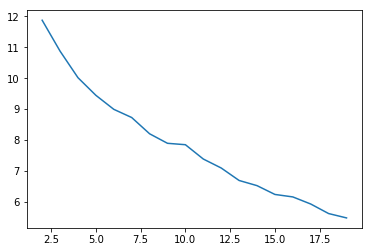

In [17]:
Ottawa_grouped_Fit = Ottawa_grouped.drop(columns=['Neighbourhood'])
scores = []
xaxis=[k for k in range(2,20)]
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Ottawa_grouped_Fit)
    scores.append(-kmeans.score(Ottawa_grouped_Fit))

plt.plot(xaxis,scores)

We see that there is an elbow at k=8 so that is what we will use for k.

In [126]:
kmeans = KMeans(n_clusters=8).fit(Ottawa_grouped_Fit)

Ottawa_grouped['Cluster']=pd.Series(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_,columns=Ottawa_grouped_Fit.columns)
centers.head()

Afghan Restaurant       Airport  Airport Service  American Restaurant  \
0           0.000000  8.673617e-19     1.626303e-19             0.001443   
1           0.001116  3.766478e-03     8.474576e-04             0.010353   
2           0.000000  0.000000e+00     0.000000e+00             0.000000   
3           0.000000  0.000000e+00     0.000000e+00             0.000000   
4           0.000000  0.000000e+00     0.000000e+00             0.000000   

         Arcade  Art Gallery    Art Museum  Arts & Crafts Store  \
0  1.372266e-03     0.003166  4.810005e-04         6.313131e-04   
1  1.871365e-03     0.000652 -5.421011e-20         2.617439e-03   
2  0.000000e+00     0.000000  0.000000e+00         0.000000e+00   
3  0.000000e+00     0.000000  0.000000e+00         0.000000e+00   
4  2.168404e-19     0.000000  0.000000e+00         2.168404e-19   

   Asian Restaurant  Athletics & Sports  ...  Turkish Restaurant  \
0          0.004016            0.005383  ...            0.001684   
1          0.010584            0.008366  ...            0.000424   
2          0.000000            0.000000  ...            0.000000   
3          0.000000            0.000000  ...            0.000000   
4          0.000000            0.000000  ...            0.000000   

   Vegetarian / Vegan Restaurant  Video Store  Vietnamese Restaurant  \
0                       0.004335      0.00000               0.012252   
1                       0.000808      0.00053               0.008104   
2                       0.000000      0.00000               0.000000   
3                       0.000000      0.00000               0.000000   
4                       0.000000      0.00000               0.000000   

   Warehouse Store     Waterfall    Whisky Bar  Wine Bar  Wings Joint  \
0    -1.734723e-18  1.262626e-03  9.469697e-04  0.002815     0.003615   
1     3.312117e-03  2.710505e-19 -1.084202e-19  0.000269     0.002432   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000     0.000000   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000     0.000000   
4     0.000000e+00 -5.421011e-20  0.000000e+00  0.000000     0.000000   

   Yoga Studio  
0     0.001443  
1     0.000269  
2     0.000000  
3     0.000000  
4     0.000000  

[5 rows x 224 columns]

Let's visualize how the distribution of clusters look on a map. Note that we split up the maps into two chuncks each. This is because folium can't handle the whole set of neighbourhoods at once.

In [45]:
!conda install -c conda-forge folium=0.8.3 --yes 
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.8.3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.8.3               |             py_0          54 KB  conda-forge

The following packages will be UPDATED:

    folium: 0.5.0-py_0 conda-forge --> 0.8.3-py_0 conda-forge


folium-0.8.3         | 54 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [148]:
newFeatures = []
otherFeatures = []
Ottawa_cleaned[Ottawa_cleaned['Cluster']>=2]
for f in response['features']:
    if f['properties']['names'] in Ottawa_cleaned[Ottawa_cleaned['Cluster'] ==3]['Neighbourhood'].values or f['properties']['names'] in Ottawa_cleaned[Ottawa_cleaned['Cluster'] ==1]['Neighbourhood'].values:
        newFeatures.append(f)
    else:
        otherFeatures.append(f)

responsePart1 = response.copy()
responsePart2 = response.copy()
responsePart1['features'] = newFeatures
responsePart2['features'] = otherFeatures


map1 = folium.Map(
    location = [45.4215,-75.6972],
    zoom_start=10
)

map1.choropleth(
    responsePart1 ,
    name='choropleth',
    data=Ottawa_cleaned,
    columns=['Neighbourhood', 'Cluster'],
    key_on='feature.properties.names',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Ottawa Neighbourhood cluster map by demographic"
)

map2 = folium.Map(
    location = [45.4215,-75.6972],
    zoom_start=10
)

map2.choropleth(
    responsePart2 ,
    name='choropleth',
    data=Ottawa_cleaned,
    columns=['Neighbourhood', 'Cluster'],
    key_on='feature.properties.names',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Ottawa Neighbourhood cluster map by demographic"
)

In [150]:
map1 ##Show cluster 1 and 3

In [151]:
map2 ##Show cluster 0,2 and 4

In [144]:
newFeatures = []
otherFeatures = []
Ottawa_cleaned[Ottawa_cleaned['Cluster']>=2]
for f in response['features']:
    if f['properties']['names'] in Ottawa_grouped[Ottawa_grouped['Cluster'] ==0]['Neighbourhood'].values or f['properties']['names'] in Ottawa_grouped[Ottawa_grouped['Cluster'] ==6]['Neighbourhood'].values:
        newFeatures.append(f)
    else:
        otherFeatures.append(f)

responsePart1 = response.copy()
responsePart2 = response.copy()
responsePart1['features'] = newFeatures
responsePart2['features'] = otherFeatures


map1 = folium.Map(
    location = [45.4215,-75.6972],
    zoom_start=10
)

map1.choropleth(
    responsePart1 ,
    name='choropleth',
    data=Ottawa_grouped,
    columns=['Neighbourhood', 'Cluster'],
    key_on='feature.properties.names',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Ottawa Neighbourhood cluster map by venue"
)

map2 = folium.Map(
    location = [45.4215,-75.6972],
    zoom_start=10
)

map2.choropleth(
    responsePart2 ,
    name='choropleth',
    data=Ottawa_grouped,
    columns=['Neighbourhood', 'Cluster'],
    key_on='feature.properties.names',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Ottawa Neighbourhood cluster map by venue"
)

In [145]:
map1 ##Show cluster 0 and 6

In [146]:
map2 ##Show cluster 1,2,3,4,5,7

In [127]:
Ottawa_grouped['Cluster'].value_counts()

1    59
0    33
6     4
4     3
3     2
2     2
7     1
5     1
Name: Cluster, dtype: int64

Now lets combine the clustering information into a single data frame and compare them.

Text(0.5, 1.0, 'Cluster similarity')

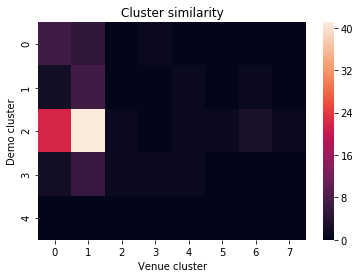

In [182]:
heatData = np.zeros((5,8))

for r,c in zip(Ottawa_cleaned['Cluster'],Ottawa_grouped['Cluster']):
    heatData[r][c]+=1

ax = sns.heatmap(heatData)
ax.set_xlabel("Venue cluster")
ax.set_ylabel("Demo cluster")
ax.set_title("Cluster similarity")

## Results and Discussion <a name="results"></a>

In this analysis, we clustered Ottawa neighbourhoods using two different methods: one using demographic information found in a geojson file and one using venue information from FourSquare. Using the demographic clustering, we see a clear division based on the geography with clusters forming sort of rings around the center of the city. This makes sense as it is typical for the population to spread outwards from a city. A fact about Ottawa is that until the 1960's, it was prohibited to build a building which was taller than the Peace Tower, the tower in Ottawa's parlement building. This caused the population to spread outwards as Ottawa grew as a city and there is a lingering effect. Another historical note is that the borders of Ottawa were changed in 2001 to include the more rural townships. We can see that the outermost neighbourhoods seem to belong to the same cluster.

For the venue clustering, there is much less geographical cohesion. Ottawa is a highly diverse city with a lil' italy, a chinatown, lil' lebanon, and so on. These would be expected to be part of their own clusters. What we see is that although the buissness seems to be in those region, this is not reflected in the demographic clustering. This suggest the represented demographic for a particular ghetto are not significantly higher in these areas compared to other places in the city, i.e. although there may be more Asian people in chinatown, there are not statistically higher than other demographics.

There seems to be poor agreement between the different clustering methodes with notable exceptions. Cluster 2 for the demographic cluster mainly include the downtown area and the area nearby. This area is also dense in similar bars, clubs, restaurents, museums, etc. Because of this, the area around downtown tends to be more homogeneous and thus part of the same cluster. This means that downtown is not only clustered by its demographics, but also its venues. Overall, apart from the downtown area, there is little connection between the population and the buissnesses.

## Conclusion <a name="Conclusion"></a>

We set out to see if there was any link between the population and the venues in a particular neighbourhood. We found that only one part of the city, downtown, had a significant number of neighbourhoods which could be clustered together by venue and demographics, simultaneously. All other sections followed different patterns, the demographic clusters following rings around downtown, and venues following ethnic ghettos.
